In [1]:
## IMPOR RELEVANT LIBRAIES

# DATA WRANGLING AND ANALYSIS
import pandas as pd
import missingno
from   skimpy import skim
import datetime as dt
import numpy as np

# DATA VISULIZATION 
import seaborn  as sns
import matplotlib.pyplot as plt

# DATE MANIPULATION
#from dateutil.relativedelta import relativedelta


In [2]:
# import relevant datasets 

# CUSTOMER DEMOGRAPHIC DATASET
cusDemo    = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 3 , parse_dates=True)

#TRASCATION DATA
transc     = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 1, parse_dates=True) 

#CUSTOMER ADDRESS
cusAddress = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 4, parse_dates=True) 


#### DATA CLEANING - transcation data 

In [46]:
# Copy the transaaction data 
trans_cleaned = transc.copy()

skim(trans_cleaned)

#Did customerss buy similar items??  - different items were purchased at diffrent timers 
trans_cleaned[trans_cleaned.customer_id == 1]

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 20002  │ │ float64     │ 7     │                                    │
│ │ Number of columns │ 13     │ │ object      │ 5     │                                    │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃         ┃ missing ┃ complete ┃ mean  ┃ sd   ┃ p0    ┃ p25   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┃         ┃         ┃ rate     ┃       ┃      ┃       ┃       ┃       ┃       ┃        ┃  │
│ ┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ transac │       1 │        1 │ 10000 │ 5800 │     1 │  5000 │ 15000 │ 20000 │ ██████ │  │
│ │ tion_id │         │          │       │      │       │       │       │       │        │  │
│ │ product │       2 │        1 │    45 │   31 │     0 │    18 │    72 │   100 │ █▅▅▅▅▅ │  │
│ │ _id     │         │          │       │      │       │       │       │       │        │  │
│ │ custome │       2 │        1 │  1700 │ 1000 │     1 │   860 │  2600 │  5000 │ ████▁  │  │
│ │ r_id    │         │          │       │      │       │       │       │       │        │  │
│ │ online_ │     360 │     0.98 │   0.5 │  0.5 │     0 │     0 │     1 │     1 │ █    █ │  │
│ │ order   │         │          │       │      │       │       │       │       │        │  │
│ │ list_pr │       2 │        1 │  1100 │  580 │    12 │   580 │  1600 │  2100 │ ▄▆▄█▅▇ │  │
│ │ ice     │         │          │       │      │       │       │       │       │        │  │
│ │ standar │     200 │     0.99 │   560 │  410 │   7.2 │   220 │   800 │  1800 │ █▅▆▂▁▁ │  │
│ │ d_cost  │         │          │       │      │       │       │       │       │        │  │
│ │ product │     200 │     0.99 │ 38000 │ 2900 │ 33000 │ 36000 │ 41000 │ 43000 │ ▇▆▆▇▇█ │  │
│ │ _first_ │         │          │       │      │       │       │       │       │        │  │
│ │ sold_d  │         │          │       │      │       │       │       │       │        │  │
│ └─────────┴─────────┴──────────┴───────┴──────┴───────┴───────┴───────┴───────┴────────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃                   ┃ missing  ┃ complete rate  ┃ first       ┃ last       ┃ frequency ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ transaction_date  │        2 │              1 │ 2017-01-01  │ 2017-12-30 │ None      │  │
│ └───────────────────┴──────────┴────────────────┴─────────────┴────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
93,94.0,86.0,1.0,2017-12-23,0.0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
3764,3765.0,38.0,1.0,2017-04-06,1.0,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
5156,5157.0,47.0,1.0,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
9784,9785.0,72.0,1.0,2017-01-05,0.0,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
13423,13424.0,2.0,1.0,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0
13643,13644.0,25.0,1.0,2017-05-19,0.0,Approved,Giant Bicycles,Road,medium,medium,1538.99,829.65,33552.0
14485,14486.0,23.0,1.0,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,33455.0
14930,14931.0,31.0,1.0,2017-12-14,1.0,Approved,Giant Bicycles,Standard,medium,medium,230.91,173.18,37337.0
15662,15663.0,32.0,1.0,2017-06-04,1.0,Approved,Giant Bicycles,Standard,medium,medium,642.70,211.37,40618.0
16422,16423.0,9.0,1.0,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,37838.0


In [47]:
# Investigate if there multiple transactions recorded 
trans_cleaned.transaction_id.duplicated().value_counts()

False    20001
True         1
Name: transaction_id, dtype: int64

In [48]:
# Convert product_first_sold_date to the right format 
trans_cleaned['product_first_sold_date'] = pd.to_datetime(trans_cleaned['product_first_sold_date'], 
                                           unit = 'D',
                                           origin ='1899-12-30' )

trans_cleaned.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1.0,2.0,2950.0,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2.0,3.0,3120.0,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3.0,37.0,402.0,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4.0,88.0,3135.0,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5.0,78.0,787.0,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


In [49]:
#Convert online type to Boolean
def changeBoolean(var):
    if var == 0.0:
        return False
    elif var == 1.0:
        return True
    
trans_cleaned['online_order'] = trans_cleaned['online_order'].apply(changeBoolean)
trans_cleaned.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1.0,2.0,2950.0,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2.0,3.0,3120.0,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3.0,37.0,402.0,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4.0,88.0,3135.0,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5.0,78.0,787.0,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


In [50]:
# ADD a profit column and profit ratio
trans_cleaned['profit']      = trans_cleaned['list_price'] - trans_cleaned['standard_cost']
trans_cleaned['profitRatio'] = trans_cleaned['list_price'] / trans_cleaned['standard_cost']

# drop columns with null profit 
trans_cleaned          = trans_cleaned[trans_cleaned['profit'].notna()]
trans_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19803 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19803 non-null  float64       
 1   product_id               19803 non-null  float64       
 2   customer_id              19803 non-null  float64       
 3   transaction_date         19803 non-null  datetime64[ns]
 4   online_order             19445 non-null  object        
 5   order_status             19803 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               19803 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [51]:
## ADD AN UNSPECIFIED COLUMN TO online_order that is na
trans_cleaned.online_order.fillna('Unspecified', inplace=True)

# Find all categorical columns 
columns = [i for i in list(trans_cleaned.columns) if trans_cleaned[i].dtype == 'O']

for item in columns:
    print(f'{item} unique Values {trans_cleaned[item].unique()}')


online_order unique Values [False True 'Unspecified']
order_status unique Values ['Approved' 'Cancelled']
brand unique Values ['Solex' 'Trek Bicycles' 'OHM Cycles' 'Norco Bicycles' 'Giant Bicycles'
 'WeareA2B']
product_line unique Values ['Standard' 'Road' 'Mountain' 'Touring']
product_class unique Values ['medium' 'low' 'high' ' ']
product_size unique Values ['medium' 'large' 'small']


In [52]:
# Observe thatcertain transactions were cancelled and note that Cancelled transactions dont add up to the revenue
trans_cleaned.order_status.value_counts() 

# Use only approved transcations 
trans_cleaned = trans_cleaned[trans_cleaned.order_status == 'Approved']

#### THE  RELEVANT METRICS I USE WILL BE 
- TOTAL AND AVERAGE REVENUE PER CUSTOMER 
- FREQUENCY OF TRANSCATION 
- AVERAGE PROFIT RATION  PER TRANSACTION 

In [53]:
transcMetrics = trans_cleaned.groupby('customer_id').agg({'profit' : ['sum', 'mean'],
                                          "customer_id" : 'count' ,
                                          'profitRatio' : ['sum', 'mean']})



#### DATA CLEANING - CUSTOMER DEMOGRAPHICS

<AxesSubplot:>

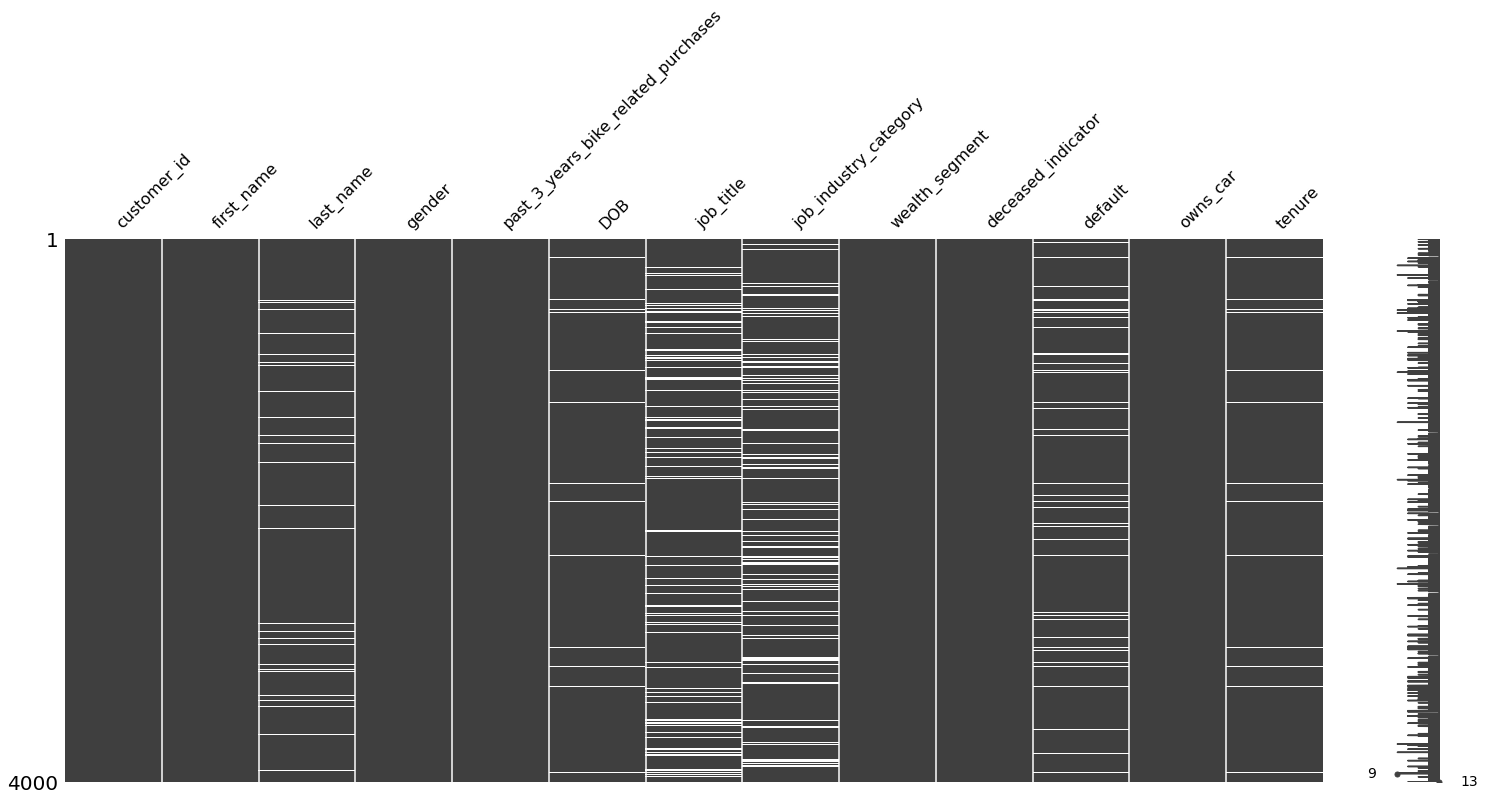

In [54]:
cusDemo_cleaned = cusDemo.copy() 
missingno.matrix(cusDemo_cleaned)

##### DROP IRRELEVANT COLUMNS 

In [55]:
'''
Drop  default column, i doesnt have a meaning
Drop  default first and last names, Name will not influence purchase pattern
'''
cusDemo_cleaned.drop(columns = ['first_name', 'last_name', 'default'], inplace = True)

#### CLEAN DATE OF BIRTH COLUMN
- Convert Date of birth to Age 
- Drop null values
- Find and drop outliers

In [56]:
# CONVERT DATE OF BIRTH TO AGE AND CLASSIFY IN TENS 
#take the maximum transcation date as the time of th project 

y  = 2017    

cusDemo_cleaned.DOB = y - cusDemo_cleaned.DOB.dt.year

cusDemo_cleaned.DOB.describe()
#It seen there is an outlier Age, Lets find out if there are more than one customer that is more than  100 years old 

count    3913.000000
mean       39.969333
std        12.796387
min        15.000000
25%        30.000000
50%        40.000000
75%        49.000000
max       174.000000
Name: DOB, dtype: float64

In [57]:
"""
Oops!, her just caught an oulier.
In a real life situation, we can verify the customer age bu in this case, i will drop the customer from our database 
and the null date of births
"""
print(cusDemo_cleaned.DOB[cusDemo_cleaned.DOB > 100])

cusDemo_cleaned = cusDemo_cleaned[cusDemo_cleaned.DOB < 100]

#Drop dull values
cusDemo_cleaned = cusDemo_cleaned[cusDemo_cleaned.DOB.notna()]


33    174.0
Name: DOB, dtype: float64


# Clean job_title','job_industry_category Columns
- Find cell is missing values
- Drop nulls in both category ---> 'job_title','job_industry_category'

In [58]:
cusDemo_cleaned.job_industry_category.isna().value_counts()

False    3256
True      656
Name: job_industry_category, dtype: int64

In [75]:
cusDemo_cleaned.dropna(how = 'any')

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,F,93,64.0,Executive Secretary,Health,Mass Customer,N,Yes,11.0
1,2,Male,81,37.0,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0
2,3,Male,61,63.0,Recruiting Manager,Property,Mass Customer,N,Yes,15.0
8,9,Female,97,44.0,Business Systems Development Analyst,Argiculture,Affluent Customer,N,Yes,8.0
9,10,Female,49,29.0,Senior Quality Engineer,Financial Services,Mass Customer,N,Yes,20.0
...,...,...,...,...,...,...,...,...,...,...
3992,3993,Female,6,43.0,Librarian,Entertainment,Mass Customer,N,No,10.0
3993,3994,Female,5,28.0,Structural Analysis Engineer,Manufacturing,Affluent Customer,N,No,12.0
3994,3995,Male,93,42.0,Staff Scientist,Manufacturing,Mass Customer,N,Yes,14.0
3995,3996,Female,8,42.0,VP Product Management,Health,Mass Customer,N,No,19.0


In [ ]:
# Attain unique job title to job industry 
job_to_title = cusDemo_cleaned[['job_title','job_industry_category']].dropna().drop_duplicates().reset_index(drop = True)

In [ ]:
job_to_title[job_to_title.job_title == 'Professor']


,job_title,job_industry_category
109,Professor,Financial Services
142,Professor,Retail
353,Professor,Manufacturing
383,Professor,Telecommunications
556,Professor,Property
562,Professor,IT
681,Professor,Health
689,Professor,Argiculture


In [ ]:
test = cusDemo[['customer_id','DOB']].dropna()
test['AGE'] = 2017 - test.DOB.dt.year
test.AGE.astype(int)

test = test[test != test.AGE.max()]

bins = np.arange(10,100,10)
labels_ = np.arange(10,90,10)
test['Grouping'] = pd.cut(test.AGE, bins, labels = labels_ )
test

,customer_id,DOB,AGE,Grouping
0,1.0,1953-10-12,64.0,60
1,2.0,1980-12-16,37.0,30
2,3.0,1954-01-20,63.0,60
3,4.0,1961-10-03,56.0,50
4,5.0,1977-05-13,40.0,30
...,...,...,...,...
3994,3995.0,1975-12-12,42.0,40
3995,3996.0,1975-08-09,42.0,40
3996,3997.0,2001-07-13,16.0,10
3998,3999.0,1973-10-24,44.0,40


#### DATA CLEANING
ALL DATA SETS ARE CLEANED INORDER TO BE PREPROCESSED.
REDUNDANT COLUMNS ARE DROPPED, MISSING VALUES ARE FILLED, CATEGORIES ARE CORRECTED. 

#### DATA WRANGLING
DATA IS WRANGLED TO FIT INTO ONE ONE DATASET 

#### COMPUTATION
- COMPUTE AGE AND CLASSIFY BY AGE BRACKET

- AN APPROPRIATE METHOD IS USED TO CLASSIFY CURRENT TARGET- 1,0 WHICH WILL CORRESEPOND TO TRUE OR FALSE
  PROBLEM?? -- EHAT METHOD CAN I USE TO DESIGN A MODEL THAT CAN EFFECTIVELY CATEGORISE TH

#### VISUALIZATION AND CLASSIFICATION OF PUCAHSE BEHAVIOURS 
EDA IS CARRIED OUT O THE EXISTING DATASET AND MORE UNDERSTANDING OF THE PURCHASE BEHAVIOURS IS ATTAINED 

#### FEATURE ENGINEERING 
THE DATA SET IS ACCUSTOMED TO BE FIT INTO A MODEL

#### DEVELOP MODEL 
IN THIS CASE, WE WILL USE A CLASSICAL CLASSIFICTION MODEL TO CLASSIFY CUSKTOMERS INTO TWO GROUPS BASED ON THEIR PURCHASE BEHAVIOUS 

#### MODEL TESTING AND VALIDATION 
THE MODEL IS TESTED WITH THE TEST DATA TO VALIDATE THE CORRECTIES NESSA ND ACCUERACY

#### MODEL DEPLOYMENT
APPLY MODEL ON THE NEW CUSTOMERS FOR CLASSIFICATION